In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read original data from 
data = pd.read_csv('../dataframes/DF_prest.csv', index_col=0)

# setup 'docs' for use with Tokenizer
def nt_seq_doc(nt_sequence):
    if 'GACAAGCTTGCGGCCGCA' not in nt_sequence:
        return None
    true_nt = nt_sequence.split('GACAAGCTTGCGGCCGCA')[1]
    if len(true_nt) % 3 != 0:
        return None
    return ' '.join([true_nt[i:i+3] 
                     for i in range(0, len(true_nt), 3)])
# split quantiles
def assign_class(conc):
    if conc <= low_cut:
        return 0
    elif conc >= high_cut:
        return 1
    return

data['nt_seq_doc'] = data['nt_seq'].apply(nt_seq_doc)
data = data[pd.notnull(data['nt_seq_doc'])]

# identify high and low classes by conc_cf quantiles
low_cut = data['conc_cf'].quantile(0.25)
high_cut = data['conc_cf'].quantile(0.75)

data['class'] = data['conc_cf'].apply(assign_class)
data = data[pd.notnull(data['class'])]
# check shape
print('data shape: ', data.shape)

data shape:  (22364, 8)


In [3]:
# define sequence documents
docs = list(data['nt_seq_doc'])
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

# integer encode documents
X = t.texts_to_sequences(docs)
y = data['class'].values

# create test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# fix random seed for reproducibility
np.random.seed(7)

# load the dataset but only keep the top n words, zero the rest
top_words = len(t.word_index) + 1

# truncate and pad input sequences
seq_lengths = [len(seq) for seq in X]
max_seq_length = max(seq_lengths)
X_train = sequence.pad_sequences(X_train, maxlen=max_seq_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_seq_length)

# Embed codons, learn w/ single Long Short Term Memory Layer

### 4 dimensional embedding

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 4
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 181, 4)            260       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 42,361
Trainable params: 42,361
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 27s 2ms/step - loss: 0.6922 - acc: 0.5111
Epoch 2/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6795 - acc: 0.5687
Epoch 3/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6559 - acc: 0.6158
Accuracy: 58.12%


### 8 dimensional embedding

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 8
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 181, 8)            520       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 44,221
Trainable params: 44,221
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6946 - acc: 0.5074
Epoch 2/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6772 - acc: 0.5687
Epoch 3/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6601 - acc: 0.6120
Accuracy: 61.67%


### 16 dimensional embedding

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 181, 16)           1040      
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 47,941
Trainable params: 47,941
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 27s 2ms/step - loss: 0.6869 - acc: 0.5315
Epoch 2/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6523 - acc: 0.6147
Epoch 3/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6479 - acc: 0.6255
Accuracy: 63.07%


### 32 dimensional embedding

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 181, 32)           2080      
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 55,381
Trainable params: 55,381
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 28s 2ms/step - loss: 0.6887 - acc: 0.5305
Epoch 2/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6515 - acc: 0.6242
Epoch 3/3
15654/15654 [==============================] - 26s 2ms/step - loss: 0.6417 - acc: 0.6379
Accuracy: 61.74%


# Hook LSTM to basic CNN

Train on 15654 samples, validate on 6710 samples
Epoch 1/15
15654/15654 [==============================] - 33s 2ms/step - loss: 0.6709 - acc: 0.5786 - val_loss: 0.6485 - val_acc: 0.6273
Epoch 2/15
15654/15654 [==============================] - 30s 2ms/step - loss: 0.6409 - acc: 0.6407 - val_loss: 0.6339 - val_acc: 0.6461
Epoch 3/15
15654/15654 [==============================] - 30s 2ms/step - loss: 0.6294 - acc: 0.6523 - val_loss: 0.6350 - val_acc: 0.6419
Epoch 4/15
15654/15654 [==============================] - 30s 2ms/step - loss: 0.6240 - acc: 0.6590 - val_loss: 0.6272 - val_acc: 0.6428
Epoch 5/15
15654/15654 [==============================] - 30s 2ms/step - loss: 0.6134 - acc: 0.6657 - val_loss: 0.6267 - val_acc: 0.6463
Epoch 6/15
15654/15654 [==============================] - 31s 2ms/step - loss: 0.6086 - acc: 0.6717 - val_loss: 0.6303 - val_acc: 0.6431
Epoch 7/15
15654/15654 [==============================] - 31s 2ms/step - loss: 0.6047 - acc: 0.6782 - val_loss: 0.6189 - val_acc:

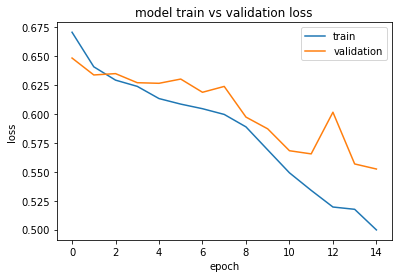

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# record training progress
history = model.fit(X_train, y_train, epochs=15, batch_size=64,
                    validation_data=(X_test, y_test))

# plot loss vs. epoch
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()